# BCGS Tutorial

Bayesian Conjugate Gibbs Sampler (BCGS) is an implementation of Markov chain monte carlo using conjugate Gibbs sampling for performing Bayesian inference. Compared to software like JAGS and BUGS, BCGS is extremely crude and limited. It exists mainly for pedagogical purposes. It may also be a convenient solution for simple inference problems, as it is written in pure Python, with no dependences beyond `numpy` and `scipy`, and requires no special installation.

## Summary

Advantages
- Written in pure python, with minimal dependences (numpy and scipy).
- Models are specified in "Probabilistic Graphical Model" format, broadly similar to that used by pymc3, JAGS and STAN, rather than by explicitly writing a function to evaluate the posterior (and/or prior, likelihood).

Limitations
- Only a few conjugate relationships are implemented, though this could be expanded.
- There is no backup sampling method for non-conjugate parameters. All parameters must be conditionally conjugate.
- Intermediate deterministic-but-not-fixed parameters cannot be used, since the code can recognize conjugacies only between directly linked parameters. Deterministic parameters other than constants therefore cannot have random variables or data downstream. Note that breaking this rule will not raise an exception; instead "detached" upstream parameters will simply end up sampling from their priors.
- No effort has been put into optimization.
- No effort is made to check validity of data or initial parameter values (e.g. Poisson data must be non-negative).
- Array-valued parameters are allowed, to the extent that numpy/scipy can discern one's intent. This can potentially lead to unexpected behavior.

## Installation

Either `pip install bcgs` or just download the source `bcgs.py` file.

## Basic usage

[These course notes](https://kipac.github.io/StatisticalMethods/) may be a useful reference for what follows, in particular the notes on 
[generative models](https://kipac.github.io/StatisticalMethods/notes/generative_models.html), 
[Bayes' law](https://kipac.github.io/StatisticalMethods/notes/bayes_law.html), 
[Markov chain monte carlo](https://kipac.github.io/StatisticalMethods/notes/montecarlo.html#Markov-Chain-Monte-Carlo) 
and [MCMC diagnostics](https://kipac.github.io/StatisticalMethods/notes/mcmc_diagnostics.html).

Let's demonstrate the use of the package on a simple problem that has an analytic solution to compare to.

In [1]:
import bcgs

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import incredible as cr

We'll consider a model where data are drawn from a Poisson distribution, and we wish to infer the mean. In fancy statistical notation, the former statement is written

$N \sim \mathrm{Poisson}(\mu)$,

where $\mu$ is the mean that we want to find, and $N$ is the data, a measured non-negative integer (e.g. the number of activations of a detector in a given time interval). In Bayesian inference, our job is to find the probability distribution of $\mu$ conditioned on the data that were gathered, $p(\mu|x)$. This _posterior_ distribution combines  the _prior_ distribution, representing what was known before gathering the data, $p(\mu)$, with the information contained in the data.

Consulting [the Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior), we find that the Poisson distribution is conjugate to the Gamma distribution. This means that, if we chose a prior that can be represented with a Gamma distribution, the posterior will also be a Gamma distribution (with parameters that depend on the data and the parameters of the prior).

BCGS (and JAGS, BUGS, etc.) take advantage of such conjugacies to efficiently generate random samples from the posterior distribution. In this particularly simple case, we could actually write down the posterior directly as a Gamma distribution, so samples are probably unnecessary. In more complex problems that nontheless contain conjugacies like that above, the posterior is generally not a simple distribution as it is here; this is when being able to generate random samples from it _anyway_ is our best approach to characterizing the posterior.

In any case, let's make up an arbitrary value for our data, here called `counts` instead of $N$.

In [2]:
counts = 5

Before we can continue, we also need to choose a prior for $\mu$. For no particular reason, let's take $p(\mu)$ to be uniform over the non-negative real line. To use BCGS for this problem (though not Bayesian inference in general), we need $p(\mu)$ to have the form of a Gamma distribution; however, it turns out that the Gamma distribution approaches uniform for shape parameter $\alpha=1$ and rate parameter $\beta \rightarrow 0$.

We could sketch the model graphically as follows:

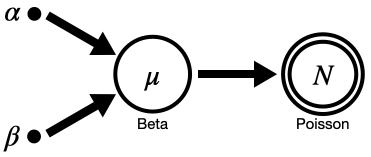

The cells below illustrate the process of constructing this model with BCGS. First we declare a `Model` object.

In [3]:
model = bcgs.Model()

Next we need to add all the parameters of the model (including the data) to `model` in generative order (that is, from beginning to end of the process one would use to generate mock data from the model, consistent with the arrows above).

So, we begin with the parameters defining the prior for $\mu$.

In [4]:
model.add("alpha", bcgs.Constant(1.0))
model.add("beta", bcgs.Constant(0.0))

The first argument to `model.add` is just a unique name for the parameter; here we've used the conventional names for the shape and rate parameters of the Gamma distribution. The second argument is a `bcgs.Parameter` object, in this case of the special `Constant` class, since we don't want $\alpha$ and $\beta$ to be variable. The values have been set to reproduce a uniform prior, as discussed above.

Next, we add a parameter for $\mu$, specifying that its prior is a Gamma distribution with parameters given by `model.alpha` and `model.beta`. (In general, parameters added to a model with `Model.add` can later be addressed as attributes of the `Model` object.) We also provide an intial guess for $\mu$ through the `value` argument; this is required for all `bcgs.Parameter` objects that will be variable on instantiation (it's the only argument for `Constant`, above).

In [5]:
model.add("mu", bcgs.Gamma(shape=model.alpha, rate=model.beta, value=counts))

Finally, we create a parameter for the data, specifying that it follows a Poisson distribution with mean `model.mu`. To indicate that $N$ is measured and therefore not variable, we pass in the measurement `counts` through the `data` argument; this makes the `value` argument redundant.

In [6]:
model.add("N", bcgs.Poisson(mean=model.mu, data=counts))

We can now generate a Markov chain that, possibly after a "burn-in" period dependent on the initial values, should sample the posterior distribution. Let's start with a short chain of length 5.

In [7]:
model.run_chain(5)

{'mu': array([[4.53666087],
        [5.28510795],
        [3.86003906],
        [8.35312166],
        [3.55047914]])}

The result is a dictionary where samples of each parameter are stored as 2D arrays. The first index corresponds to the iteration, and the second allows for the possibility of non-scalar parameter values (these are flattened so that the array stored in the result is always 2D). Note that only `mu` is present here, since the other parameters were not variable and therefore have the same values at each iteration. `model.add` has a `trace` argument that can be used to change this default behavior, e.g. to _not_ return the values of some parameter that is not of interest.

This format may not be the most convenient, so `Model` also provides a function to convert it as follows.

In [8]:
model.chain_dict_to_array( model.run_chain(5) )

(['mu'],
 array([[7.17389858],
        [2.7212936 ],
        [7.08521827],
        [5.81931173],
        [3.72119227]]))

The first entry of the result is a list of parameter names, and the second is a 2D array where the values for each parameter are concatenated (in the same order) side by side.

With that, let's run a longer chain.

In [9]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )

CPU times: user 4.97 s, sys: 63.8 ms, total: 5.03 s
Wall time: 5.29 s


This function will display the value of the parameter(s) at each iteration.

In [10]:
def plot_traces(chain, **kwargs):
    param_labels, ch = chain
    plt.rcParams['figure.figsize'] = (16.0, 3.0*len(param_labels))
    fig, ax = plt.subplots(len(param_labels), 1);
    cr.plot_traces(ch, ax, labels=param_labels, Line2D_kwargs={'markersize':1.0}, **kwargs)

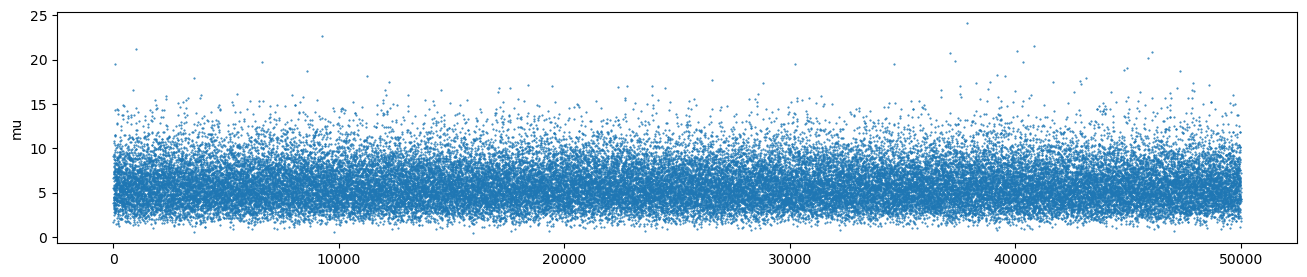

In [11]:
plot_traces(chain)

The distribution of values seems to be stable over the entire chain, which is a good sign.

Since we know the exact posterior distribution for this case, we can also verify that the sampler worked correctly. Below, we compare a histogram of the samples (the blue curve is a smoothed version of this) with the analytic posterior density (orange circles).

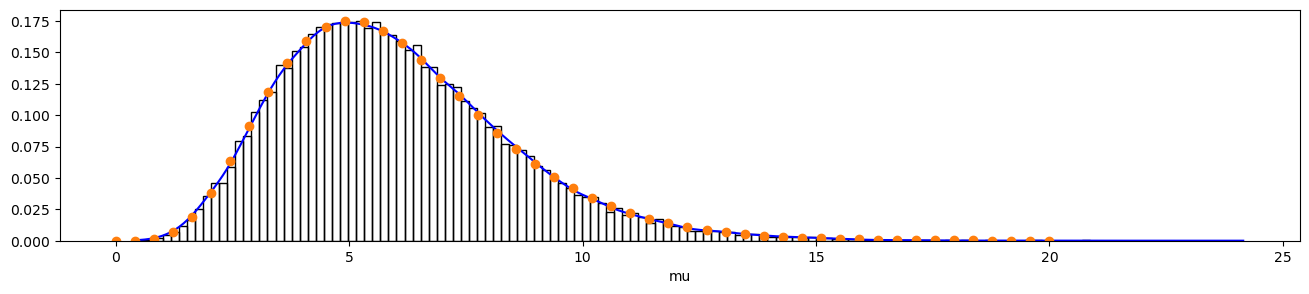

In [12]:
h1 = cr.whist(chain[1][:,0], plot=plt)
xx = np.linspace(0.0, 20.0)
plt.plot(xx, st.gamma.pdf(xx, model.alpha.value+model.N.data, scale=1./(model.beta.value+1)), 'o');
plt.xlabel('mu');

## Array-valued data

Often, more than one measurement arises from the same model.

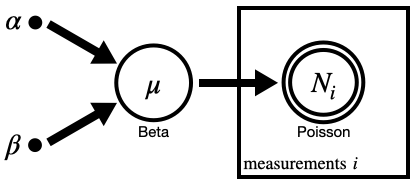

This is handled transparently by passing a list or array (of any dimension) to the `data` argument when creating the corresponding parameter.

Let's try this with the previous example, imagining we have these 10 measurements from a common Poisson distribution.

In [13]:
counts2 = [5, 3, 6, 5, 5, 9, 6, 8, 5, 2]

Here is the model definition. Note that the only change is to pass `counts2` instead of `counts` in the last line.

In [14]:
model = bcgs.Model()

# hyperparameters for mu, corresponding to the uniform limit of the Gamma distribution
model.add("alpha", bcgs.Constant(1.0))
model.add("beta", bcgs.Constant(0.0))

# parameter of interest - starting guess is `counts`
model.add("mu", bcgs.Gamma(shape=model.alpha, rate=model.beta, value=counts))

# data
model.add("N", bcgs.Poisson(mean=model.mu, data=counts2))

Here's the chain:

CPU times: user 4.67 s, sys: 34.2 ms, total: 4.71 s
Wall time: 4.71 s


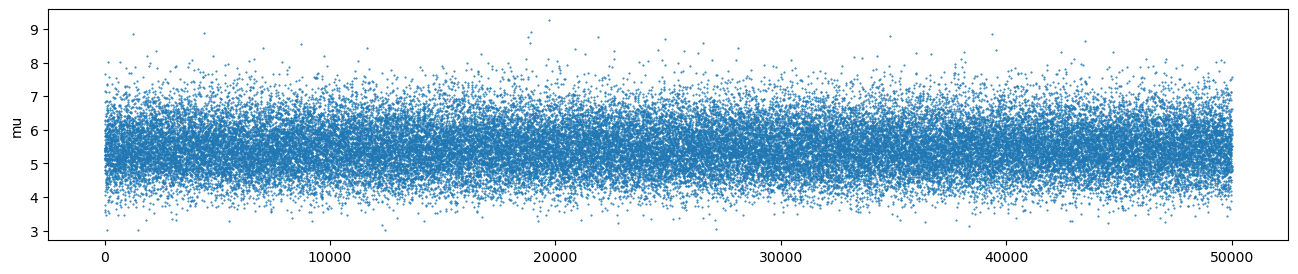

In [15]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )
plot_traces(chain)

And we can again verify that the results agree with the analytic solution for this larger data set.

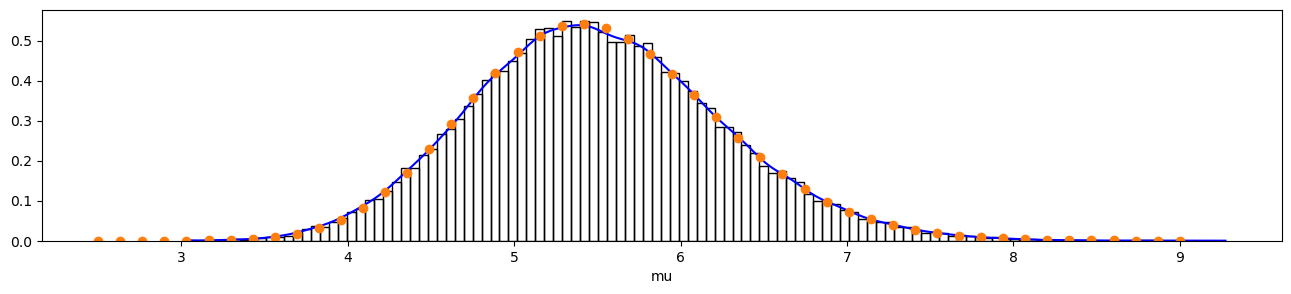

In [16]:
h1 = cr.whist(chain[1][:,0], plot=plt)
xx = np.linspace(2.5, 9.0)
plt.plot(xx, st.gamma.pdf(xx, model.alpha.value+np.sum(counts2), scale=1./(model.beta.value+np.size(counts2))), 'o');
plt.xlabel('mu');

## Predicting new data

One can use the modeling framework to make posterior predictions for new data, or any function of the model parameters. (Though note that, in this case, doing so is much less efficient that performing such calculations with the chain already in hand.)

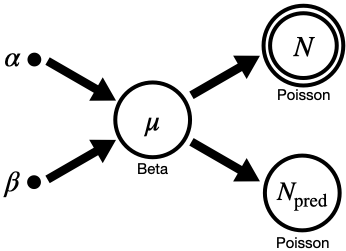

Below, we add a parameter for predicted new data, `Npred`, to the model. Like the real data, it is generated from a Poisson distribution with mean `model.mu`, but note that we do not provide a `data` argument, only an initial value.

In [17]:
model = bcgs.Model()

# hyperparameters for mu, corresponding to the uniform limit of the Gamma distribution
model.add("alpha", bcgs.Constant(1.0))
model.add("beta", bcgs.Constant(0.0))

# parameter of interest - starting guess is `counts`
model.add("mu", bcgs.Gamma(shape=model.alpha, rate=model.beta, value=counts))

# data
model.add("N", bcgs.Poisson(mean=model.mu, data=counts))

# prediction for more data (needs a starting value like anything else)
model.add("Npred", bcgs.Poisson(mean=model.mu, value=counts))

The resulting chain contains samples of both `mu` and `Npred` from their joint posterior distribution.

CPU times: user 9.87 s, sys: 30.5 ms, total: 9.9 s
Wall time: 9.92 s


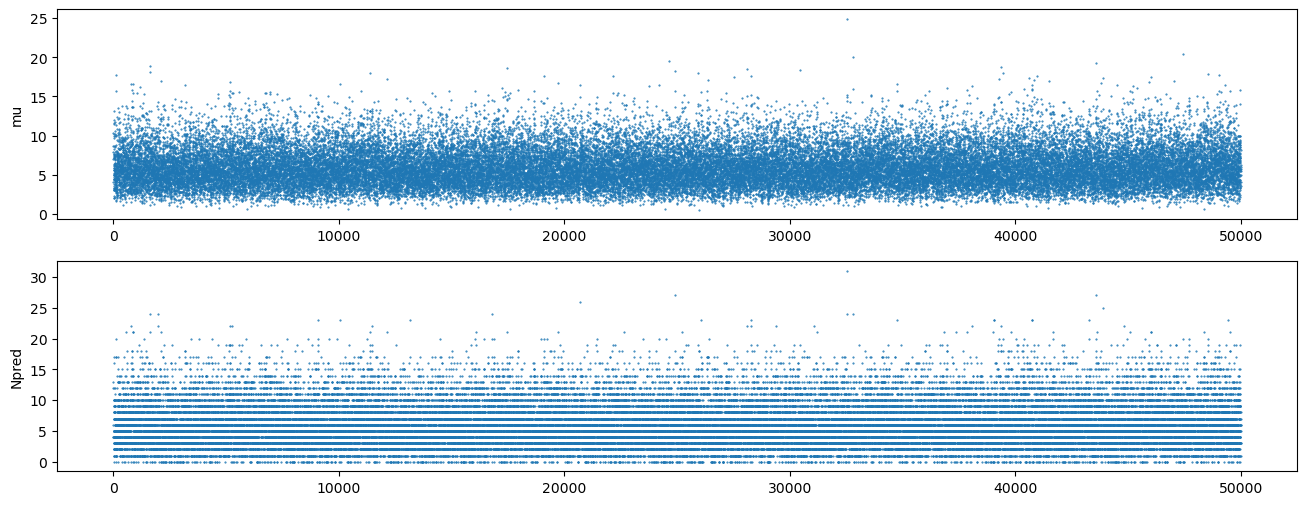

In [18]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )
plot_traces(chain)

The posterior for `mu` remains correct.

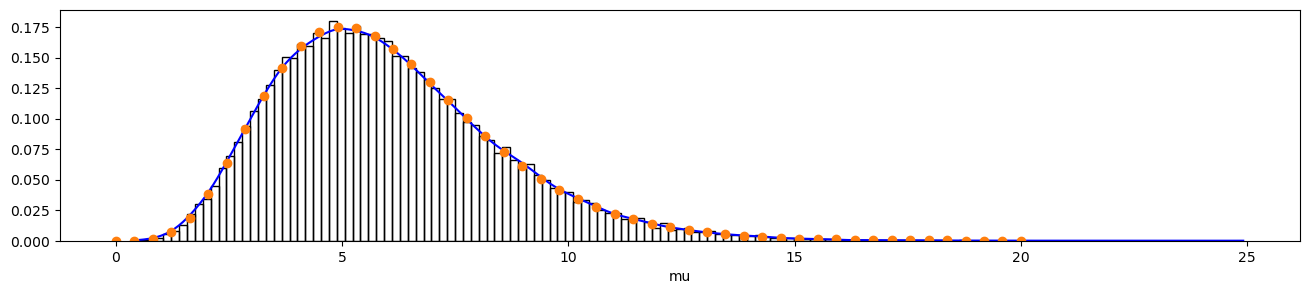

In [19]:
plt.rcParams['figure.figsize'] = (16.0, 3.0)
h1 = cr.whist(chain[1][:,0], plot=plt)
xx = np.linspace(0.0, 20.0)
plt.plot(xx, st.gamma.pdf(xx, model.alpha.value+model.N.data, scale=1./(model.beta.value+1)), 'o');
plt.xlabel('mu');

We can also check that the samples of `Npred` match the correct distribution.

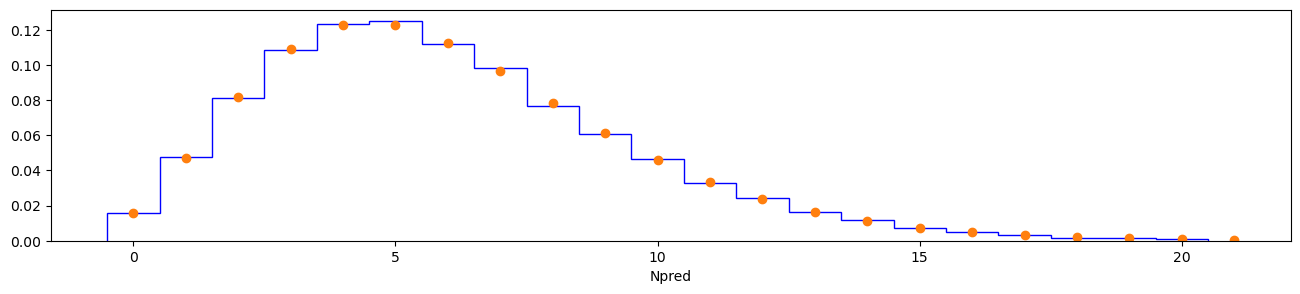

In [20]:
plt.rcParams['figure.figsize'] = (16.0, 3.0)
bins = np.arange(22)-0.5
plt.hist(chain[1][:,1], bins=bins, density=True, histtype='step', color='b');
plt.plot(bins+0.5, st.nbinom.pmf(bins+0.5, model.alpha.value+model.N.data, (model.beta.value+1)/(model.beta.value+2)), 'o', color='C1');
plt.xlabel('Npred');

## Using deterministic quantities

Once can define parameters that are deterministic functions of other parameters. A major limitation is that BCGS only recognizes conjugacies when parameters are directly linked to one another; hence it will not work correctly if a deterministic parameter is "in between" two variable parameters, or between a variable parameter and data. This functionality is therefore only useful for keeping track of functions of parameters that we would rather not compute once the chains are in hand.

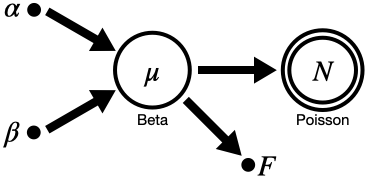

Below, we introduce $F=0.01\mu$, a deterministic function of $\mu$. We first need to define a python function:

In [21]:
def myfun(x):
    return 0.01*x

We then create the model, including a `Determinisic` parameter. The first argument to the constructor is the function itself, and all remaining arguments are `bcgs.Parameter` objects whose values will be passed to that function to find the value of the deterministic parameter.

In [22]:
model = bcgs.Model()

# hyperparameters for mu, corresponding to the uniform limit of the Gamma distribution
model.add("alpha", bcgs.Constant(1.0))
model.add("beta", bcgs.Constant(0.0))

# parameter of interest - starting guess is `counts`
model.add("mu", bcgs.Gamma(shape=model.alpha, rate=model.beta, value=counts))

# this thing is computed from mu
model.add("F", bcgs.Deterministic(myfun, model.mu))

# data
model.add("N", bcgs.Poisson(mean=model.mu, data=counts))

Here is the resulting chain:

CPU times: user 5.6 s, sys: 43.9 ms, total: 5.64 s
Wall time: 5.67 s


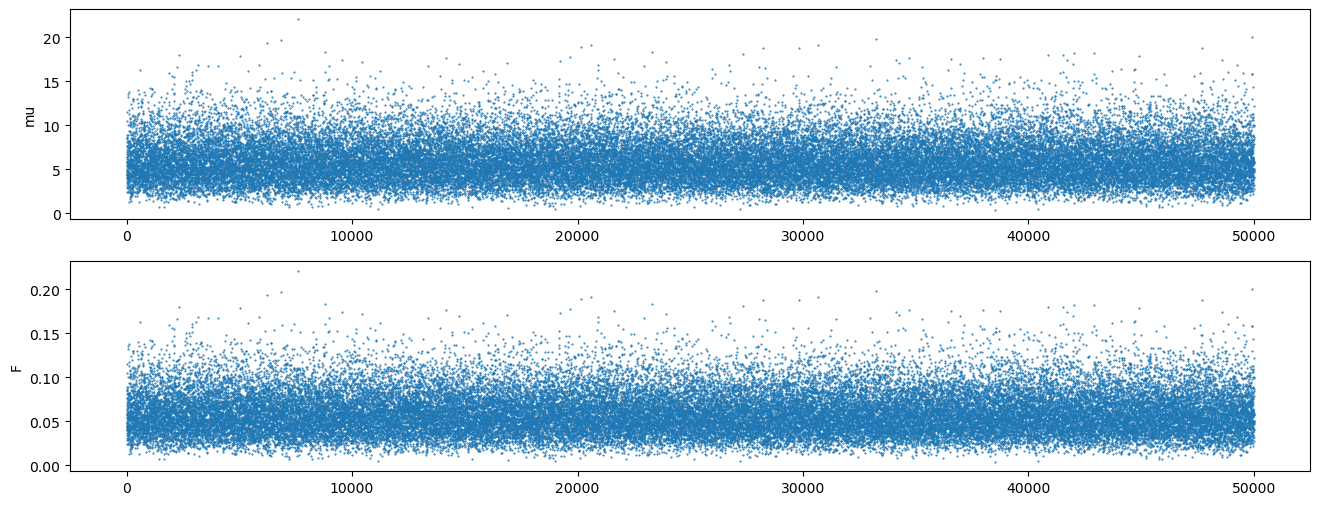

In [23]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )
plot_traces(chain)

## More examples

### Beta-Binomial

Without elaboration, this section illustrates finding the probability parameter of a Binomial distribution, which is conjugate to the Beta distribution. Like the previous example, there is an analytic solution that we can compare to.

In [24]:
model = bcgs.Model()

# prior hyperparameters for `p`, equivalent to uniform on [0,1]
model.add("alpha", bcgs.Constant(1.0))
model.add("beta", bcgs.Constant(1.0))

# parameter of interest
model.add("p", bcgs.Beta(alpha=model.alpha, beta=model.beta, value=0.5))

# data - we need to specify the number of trials as a Constant
model.add("n", bcgs.Constant(361))
model.add("k", bcgs.Binomial(p=model.p, n=model.n, data=57))

CPU times: user 6.02 s, sys: 94.2 ms, total: 6.11 s
Wall time: 6.47 s


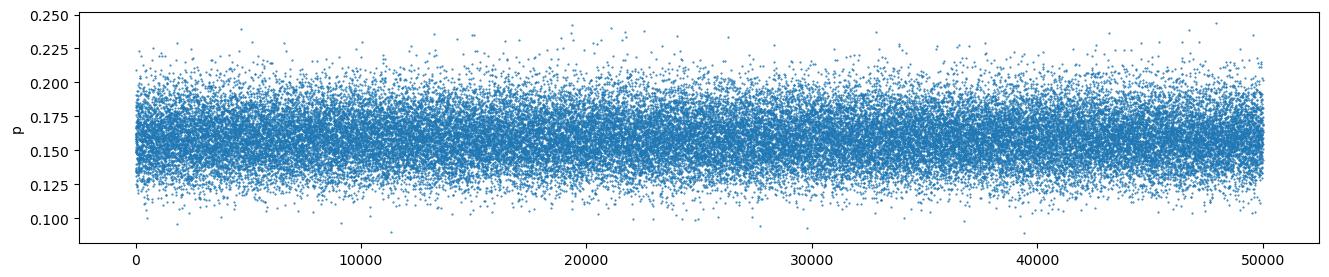

In [25]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )
plot_traces(chain)

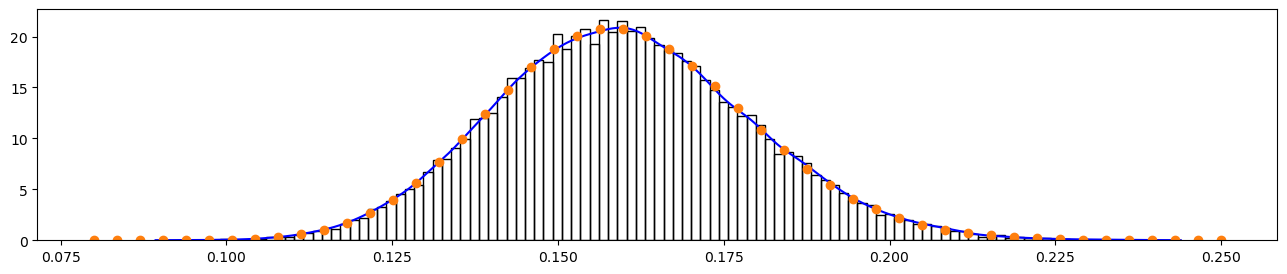

In [26]:
h1 = cr.whist(chain[1][:,0], plot=plt)
xx = np.linspace(0.08, 0.25)
plt.plot(xx, st.beta.pdf(xx, model.alpha.value+model.k.value, model.beta.value+model.k.n.value-model.k.value), 'o');

### Normal

Without elaboration, in this section we generate normally distributed data and infer the mean (conjugate to the normal distribution) and standard deviation (the variance is conjugate to the scaled inverse chisquare distribution). In leiu of comparing to an analytic solution, the true mean and standard deviation used to create the data are shown as orange lines in the final plots.

In [27]:
normaldata = st.norm.rvs(np.pi, np.sqrt(np.e), size=128)

In [28]:
model = bcgs.Model()

# prior hyperparameters for mean, equivalent to uniform
model.add("m0", bcgs.Constant(1.0))
model.add("v0", bcgs.Constant(100.0))

# mean parameter (could also have made this Constant if we wanted to fix it)
model.add("mu", bcgs.Normal(mean=model.m0, variance=model.v0, value=1.))

# prior hyperparameters for variance; prior will be inversely proportional to the variance
model.add("nu0", bcgs.Constant(0.0))
model.add("S0", bcgs.Constant(1.0))

# variance parameter (could also have made this Constant if we wanted to fix it)
# for a change, let's trace the standard deviation instead
model.add("sigma2", bcgs.ScaledInverseChisquare(dof=model.nu0, variance=model.S0, value=8.), trace=False)
model.add("sigma", bcgs.Deterministic(np.sqrt, model.sigma2))

# data
model.add("x", bcgs.Normal(mean=model.mu, variance=model.sigma2, data=normaldata))

CPU times: user 8.45 s, sys: 86.5 ms, total: 8.54 s
Wall time: 8.56 s


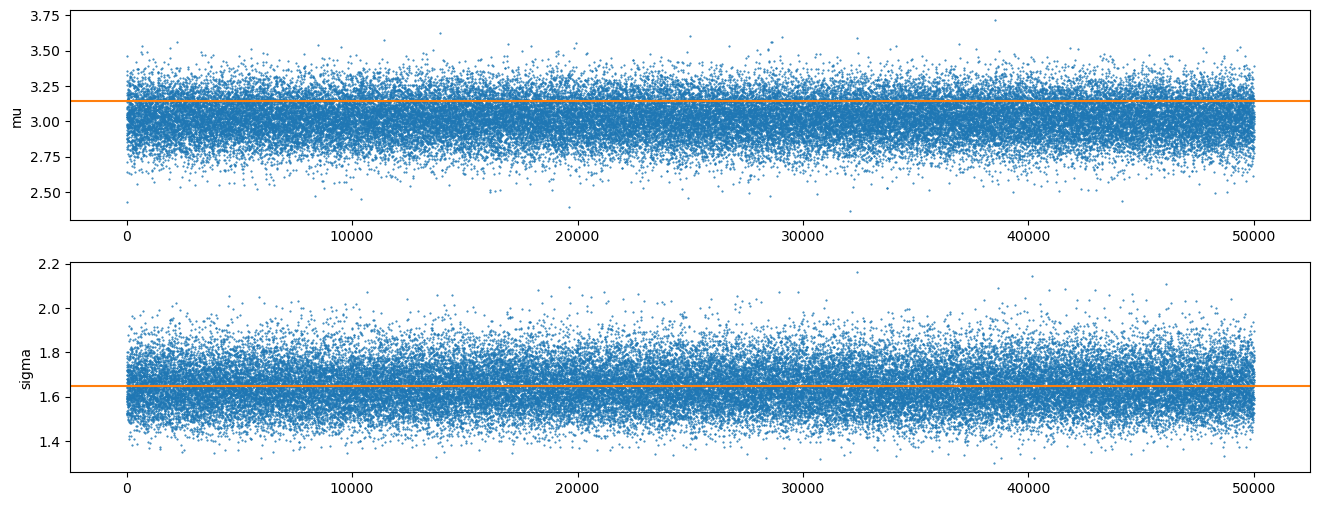

In [29]:
%time chain = model.chain_dict_to_array( model.run_chain(50000) )
plot_traces(chain, truths=[np.pi, np.sqrt(np.e)])

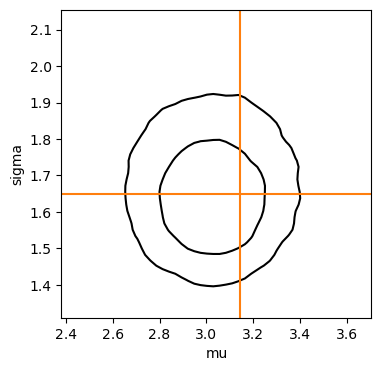

In [30]:
h2 = cr.whist2d(chain[1][:,0], chain[1][:,1], bins=50, smooth=1, plot=None)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
cr.whist2d_ci(h2, mode_fmt=None);
plt.axhline(np.sqrt(np.e), color='C1');
plt.axvline(np.pi, color='C1');
plt.xlabel('mu');
plt.ylabel('sigma');